# Multilayer perceptron classifier for news sentiment

The financial news sentiment dataset has about 4846 records of financial news and corresponinding sentiment. The sentiments include 'positive', 'neutral' and 'negative'. 
The below code will load, precess data and use the mulilayer perceptron .

### Create a spark session and load the Financial News Data set

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('FinancialNewsDL').getOrCreate()

In [0]:
#spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

file_location = "/FileStore/FinancialNewsSentiment.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = ","

df_news = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)\

#end loading

In [0]:
df_news = df_news.withColumnRenamed("_c0","label")
df_news = df_news.withColumnRenamed("_c1","news")

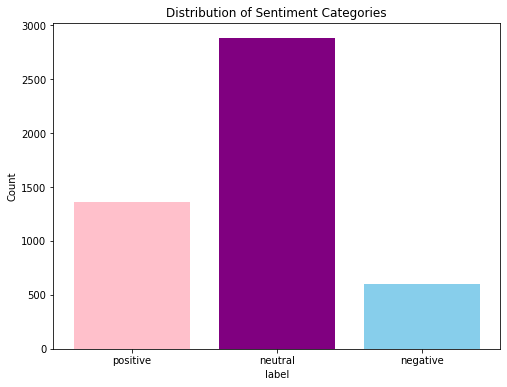

In [0]:
import matplotlib.pyplot as plt

# Group by sentiment and count the occurrences
sentiment_counts = df_news.groupBy('label').count().collect()

# Extract sentiment categories and counts
sentiments = [row['label'] for row in sentiment_counts]
counts = [row['count'] for row in sentiment_counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['pink', 'purple', 'skyblue'])
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Categories')
plt.show()

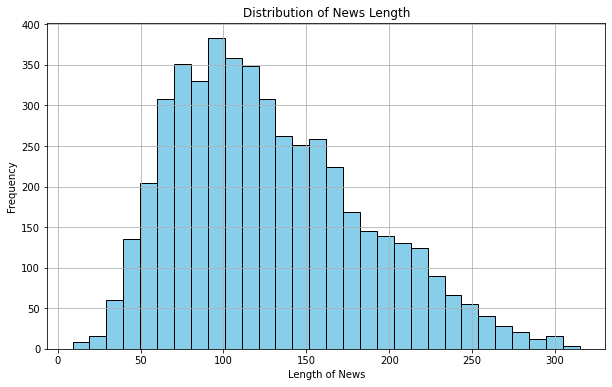

Descriptive Statistics for News Length:
  summary         news_length
0   count                4846
1    mean   128.1320676846884
2  stddev  56.526179541123554
3     min                   9
4     max                 315


In [0]:
from pyspark.sql.functions import length

# Calculate the length of each news article
df_news = df_news.withColumn('news_length', length('news'))

# descriptive analysis
length_stats = df_news.select('news_length').describe().toPandas()

# Visualize the distribution of news length using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_news.select('news_length').rdd.flatMap(lambda x: x).collect(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of News')
plt.ylabel('Frequency')
plt.title('Distribution of News Length')
plt.grid(True)
plt.show()

# descriptive statistics
print("Descriptive Statistics for News Length:")
print(length_stats)


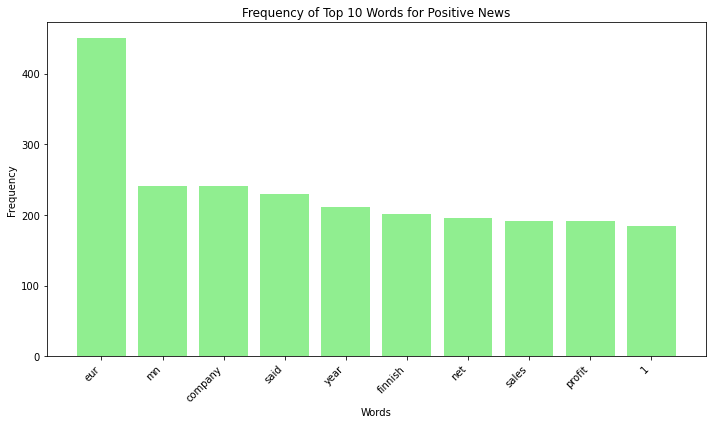

In [0]:
from pyspark.sql.functions import col, explode, split
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt

# Tokenize the text of positive news 
tokenizer = RegexTokenizer(inputCol="news", outputCol="words", pattern="\\W+")
df_news_tokenized = tokenizer.transform(df_news)


remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_news_filtered = remover.transform(df_news_tokenized)
df_news_positive= df_news_filtered.filter(df_news_filtered["label"]=="positive")

# Explode the filtered words into separate rows
df_words_exploded = df_news_positive.select(explode("filtered_words").alias("word"))

# Count the frequency of each word
word_counts = df_words_exploded.groupBy("word").count()

# Sort the words based on their frequency in descending order
word_counts_sorted = word_counts.orderBy(col("count").desc())
# Select the top 10 most frequent words
top_10_words = word_counts_sorted.limit(10)

# Convert DataFrame to Pandas DataFrame for visualization
top_10_words_pd = top_10_words.toPandas()

# Visualize the frequency of the top 10 words using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='lightgreen')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words for Positive News')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

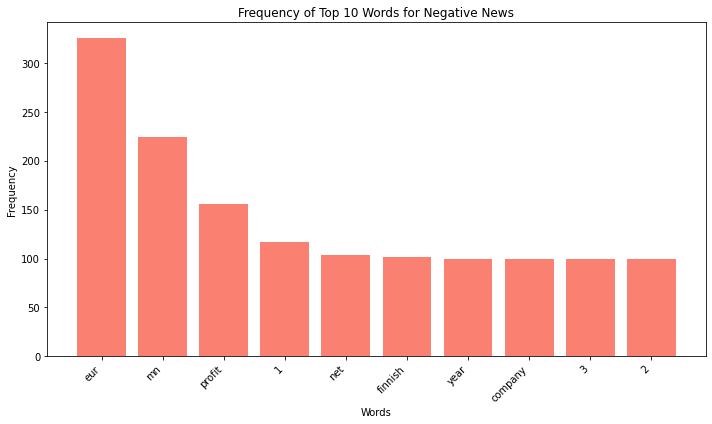

In [0]:
df_news_negative= df_news_filtered.filter(df_news_filtered["label"]=="negative")

# Explode the filtered words into separate rows
df_words_exploded = df_news_negative.select(explode("filtered_words").alias("word"))

# Count the frequency of each word
word_counts = df_words_exploded.groupBy("word").count()

# Sort the words based on their frequency in descending order
word_counts_sorted = word_counts.orderBy(col("count").desc())

# Select the top 10 most frequent words
top_10_words = word_counts_sorted.limit(10)

# Convert DataFrame to Pandas DataFrame for visualization
top_10_words_pd = top_10_words.toPandas()

# Visualize the frequency of the top 10 words using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='salmon')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words for Negative News')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Data processing

In [0]:
df_news = df_news.dropna()

In [0]:
# Create a 70-30 train test split

train_data,test_data=df_news.randomSplit([0.7,0.3])

### Building the MultiLayerPerceptron model

In [0]:
import pyspark.sql.functions as f

In [0]:
# Index label column as it is category variable - positive, negative, neutral
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol="label",outputCol="indexedLabel")
#labelIndexer = labelIndexer.fit(df_news)

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="news", outputCol="words")

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures= 4000)

idf = IDF(inputCol="rawFeatures", outputCol="features")

In [0]:
# Import the required libraries
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [0]:
# Create an object for the MultilayerPerception model

layers = [4000,128,64,3]
mlpModel = MultilayerPerceptronClassifier(maxIter=50, layers= layers, seed=1984, blockSize=128, featuresCol="features", labelCol= "indexedLabel")

In [0]:
# Pipeline is used to pass the data through indexer, tokenizer, TF-IDF simultaneously. Also, it helps to pre-rocess the test data in the same way as that of the train data. It also 
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[labelIndexer,tokenizer,hashingTF,idf,mlpModel])


In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe

result = fit_model.transform(test_data)

In [0]:
result.select("indexedLabel","prediction").show()

+------------+----------+
|indexedLabel|prediction|
+------------+----------+
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       1.0|
|         2.0|       1.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       0.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       0.0|
+------------+----------+
only showing top 20 rows



### Evaluating the model

##### Accuracy

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
pred_and_actual = result.select("prediction","indexedLabel").withColumnRenamed("indexedLabel","label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("The accuracy of the model is {}".format(evaluator.evaluate(pred_and_actual)))
#print(str(evaluator.evaluate(pred_and_actual)))

The accuracy of the model is 0.7297111416781293


##### Confusion Matrix

In [0]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
#important: need to cast to float type, and order by prediction, else it won't work
pred_and_actual = result.select(['prediction','indexedLabel']).withColumn('label', f.col('indexedLabel').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
pred_and_actual = pred_and_actual.select(['prediction','label'])

metrics = MulticlassMetrics(pred_and_actual.rdd.map(tuple))

#print(metrics.confusionMatrix().toArray())
print("Below is the confusion matrix \n {}".format(metrics.confusionMatrix().toArray()))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Below is the confusion matrix 
 [[681. 126.  33.]
 [125. 268.  24.]
 [ 44.  41. 112.]]


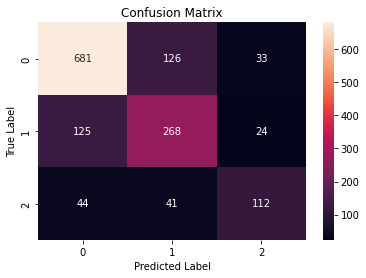

In [0]:
# Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = metrics.confusionMatrix().toArray()
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#####  Area under the ROC

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexedLabel',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(result)
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7744619590507213


A roughly 77% area under ROC denotes the model has performed reasonably well in predicting the sentiment of financial news

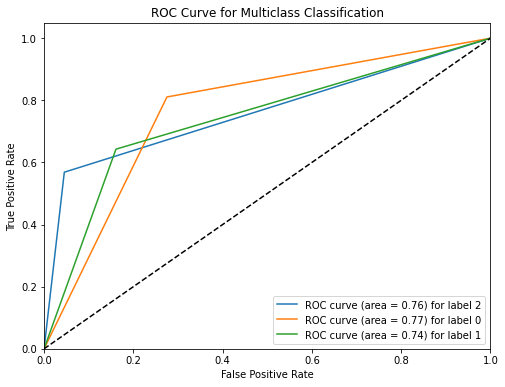

In [0]:
 from sklearn.metrics import roc_curve, auc

# Convert DataFrame to Pandas DataFrame
pred_and_actual_pd = pred_and_actual.toPandas()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get unique labels
labels = pred_and_actual_pd['label'].unique()

for label in labels:
 # Create binary labels for each class
    y_true = (pred_and_actual_pd['label'] == label).astype(int)
    y_score = pred_and_actual_pd['prediction'].apply(lambda x: 1 if x == label else 0)

    # Compute ROC curve
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    
    # Compute AUC
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for label in labels:
    plt.plot(fpr[label], tpr[label], label='ROC curve (area = %0.2f) for label %d' % (roc_auc[label], label))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

#####  Area under the PR

In [0]:
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexedLabel',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(result)
print("The area under the PR curve is {}".format(PR))

The area under the PR curve is 0.7256392974249808


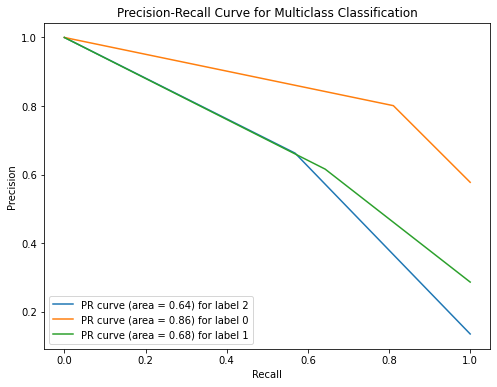

In [0]:
from sklearn.metrics import precision_recall_curve

# Convert DataFrame to Pandas DataFrame
pred_and_actual_pd = pred_and_actual.toPandas()

# Compute precision-recall curve and AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()

# Get unique labels
labels = pred_and_actual_pd['label'].unique()

for label in labels:
    # Create binary labels for each class
    y_true = (pred_and_actual_pd['label'] == label).astype(int)
    y_score = pred_and_actual_pd['prediction'].apply(lambda x: 1 if x == label else 0)

    # Compute precision-recall curve
    precision[label], recall[label], _ = precision_recall_curve(y_true, y_score)
    
    # Compute AUC for precision-recall curve
    pr_auc[label] = auc(recall[label], precision[label])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))

for label in labels:
    plt.plot(recall[label], precision[label], label='PR curve (area = %0.2f) for label %d' % (pr_auc[label], label))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend(loc="lower left")
plt.show()


### Save Model

In [0]:
#set / load basePath
basePath = "/FileStore/finalproject"

##### Save the pipeline

In [0]:
pipe.write().overwrite().save(basePath + "/pipeline")

##### Save trained model (pipeline)

In [0]:
fit_model.write().overwrite().save(basePath + "/model")